In [109]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import pandas as pd
from scipy.spatial.transform import Rotation
from pyproj import Proj, transform

In [2]:
camera_mtx = np.array([[511.03573247, 0.000000, 311.80346835], [0.000000, 508.22913692, 261.56701122], [0.000000, 0.000000, 1.000000]])
R = np.array([[1.000000, 0.000000, 0.000000], [0.000000, 1.000000, 0.000000], [0.000000, 0.000000, 1.000000]])
D = np.array([-0.43339599, 0.18974767, -0.00146426, 0.00118333, 0.000000])
image = cv2.imread("sample/thermal-25080.tiff")
# image = cv2.imread("sample/mono-12540.jpg")
height, width, _ = image.shape
map1,map2=cv2.initUndistortRectifyMap(camera_mtx, D, None, None, (width, height), cv2.CV_32FC1)

mapped = cv2.remap(image, map1, map2, cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0, 0))



In [49]:
alignment_data = pd.read_csv("sample/alignment_data.csv")
alignment_data = alignment_data.applymap(lambda x: x.strip() if isinstance(x, str) else x)
image_data = alignment_data[alignment_data['image'] == "images/thermal/thermal-25080.tiff"]
alignment_data.head()

,Time,image,camNED_qw,camNED_qx,camNED_qy,camNED_qz,camNED_vN,camNED_vE,camNED_vD,camNED_N,...,uavNED_qw,uavNED_qx,uavNED_qy,uavNED_qz,uavNED_N,uavNED_E,uavNED_D,uavLLA_lat,uavLLA_lon,uavLLA_alt
0,0.000,images/thermal/thermal-00000.tiff,-0.011084,0.980244,0.078500,0.181208,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.017,images/thermal/thermal-00001.tiff,-0.011076,0.980235,0.078551,0.181234,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.033,images/thermal/thermal-00002.tiff,-0.011061,0.980230,0.078564,0.181257,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.050,images/thermal/thermal-00003.tiff,-0.011042,0.980229,0.078538,0.181276,NaN,NaN,NaN,0.001,...,NaN,NaN,NaN,NaN,0.001,-0.000,-0.003,34.134350208,-118.127098205,192.164
4,0.067,images/thermal/thermal-00004.tiff,-0.011045,0.980232,0.078481,0.181283,NaN,NaN,NaN,0.004,...,NaN,NaN,NaN,NaN,0.004,-0.002,-0.011,34.134350234,-118.127098222,192.172


In [50]:
alt = image_data['  camNED_D'].values.astype(float)[0]

In [62]:
quat = image_data[["camNED_qw", "camNED_qx", "camNED_qy", "camNED_qz"]].values[0]
rot = Rotation.from_quat(quat)
euler = rot.as_euler("xyz", degrees=False)
pitch = euler[1]
theta = 1.5708 - pitch

In [64]:
distance_to_mid = -alt * np.tan(theta)
distance_to_mid

110.77844811351069

In [147]:
fovy = 2 * np.arctan(height / (2 * (camera_mtx[1][1])))
fovx = 2 * np.arctan(width / (2 * camera_mtx[0][0]))

In [148]:
fovx, fovy

(1.1188938114900242, 0.9332220953208663)

In [146]:
P = np.array([[511.03573247, 0.000000, 311.80346835, 0.000000], [0.000000, 508.22913692, 261.56701122, 0.000000], [0.000000, 0.000000, 1.000000, 0.000000]]).astype(np.float64())
# Decompose projection matrix

# Camera coordinates
camera_coords = np.array([[320.0, 240.0]]).astype(np.float64())
camera_coords_homo = cv2.convertPointsToHomogeneous(camera_coords)


world_coords = cv2.perspectiveTransform(camera_coords_homo, P)[0]

In [143]:
lat, lon = image_data[["     camLLA_lat", "     camLLA_lon"]].values[0].astype(float)
utm_zone = "11S"

In [144]:
lat, lon

(34.134415689, -118.126833731)

In [141]:
inProj = Proj(proj='stere', zone=11, ellps='WGS84', lat_0=lat, lon_0=lon)
outProj = Proj(proj='longlat', datum='WGS84')

# Convert 3D world coordinates to latitude and longitude
lat_point, lon_point = transform(inProj, outProj, world_coords[0, 0], world_coords[0, 1])

print("Latitude:", lat_point)
print("Longitude:", lon_point)

Latitude: -116.32741805017655
Longitude: 35.22309167022697


/tmp/ipykernel_18302/1169592191.py:5: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lat_point, lon_point = transform(inProj, outProj, world_coords[0, 0], world_coords[0, 1])


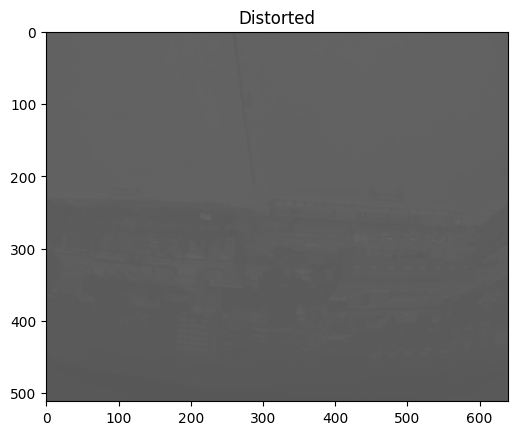

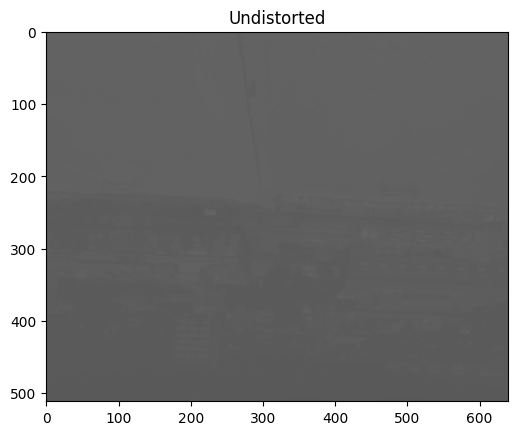

In [69]:
plt.figure()
plt.imshow(image, interpolation='nearest')
plt.title("Distorted")

plt.figure()
plt.imshow(mapped, interpolation='nearest')
plt.title("Undistorted")
plt.show()